In [1]:
# import usual libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import f1_score

# our system imports
from aideme import *

%matplotlib inline

In [2]:
def plot_fscore(metrics):
    df_list = [pd.DataFrame.from_dict({i: metric for i, metric in enumerate(ls)}, orient='index') for ls in metrics]
    avg = sum([df['fscore'][~df['fscore'].isna()] for df in df_list]) / len(df_list)
    avg.plot(ylim=[0,1], marker='o')
    plt.show()

In [3]:
# DUMMY DATA
N = int(1e6)
dim = 2
limit = 2 * (0.001)**(1. / dim)
rng = np.random.RandomState(0)
X = rng.uniform(low=-2, high=2, size=(N, dim))  # do not forget to standardize the data. For this distribution, it should be fine without it.
y_subspace = np.vstack([np.abs(X[:, i]) < limit for i in range(dim)]).T.astype('float')  # partial labels (for each subspace)
y = y_subspace.min(axis=1)

index = -10 * np.arange(len(X))
labeled_set = LabeledSet(y, y_subspace, index)

# visualize data distribution
print('selectivity :', 100 * y.sum() / len(y), '%')

#plt.figure(figsize=(10,8))
#plt.scatter(X[:, 0], X[:, 1], s=0.5, c=['b' if lb else 'r' for lb in y])
#plt.show()

selectivity : 0.1003 %


# NO FACTORIZATION EXAMPLE

In [7]:
# SET-UP EXPLORATION CONFIGURATION
REPEAT = 1
NUMBER_OF_ITERATIONS = 100  # number of points to be labeled by the user

SUBSAMPLING = 50000

INITIAL_SAMPLER = stratified_sampler(labeled_set, pos=1, neg=1)  # start with one random positive sample and one random negative sample
#INITIAL_SAMPLER = random_sampler(10)

CALLBACK = [ # callback functions to be called at the end of each iteration
    classification_metrics(labeled_set.labels, ['fscore']), 
    three_set_metric,
]
CALLBACK_SKIP = 4
PRINT_CALLBACK_RESULT = True

CONVERGENCE_CRITERIA = [
    max_iter_reached(NUMBER_OF_ITERATIONS),
    #all_points_are_known,
    #metric_reached_threshold('fscore', 0.8),
    #metric_reached_threshold('tsm', 0.9),
]

SEED = list(range(REPEAT))

explore = PoolBasedExploration(INITIAL_SAMPLER, SUBSAMPLING, CALLBACK, CALLBACK_SKIP, PRINT_CALLBACK_RESULT, CONVERGENCE_CRITERIA)

# Non-Factorized AL
#learner = RandomSampler(SVC(C=1e5, kernel='rbf', gamma='auto'))  # choose a random point
#learner = SimpleMargin(C=1024, kernel='rbf')  # choose point closest to SVM decision boundary
#learner = DualSpaceModel(learner, sample_unknown_proba=0.5, mode='positive')  # Dual Space model

learner = KernelQueryByCommittee(strategy='default', rounding_cache=True, z_cut=False, jitter=1e-12, warmup=100, thin=100, n_samples=16)  # version space algorithm
#learner = KernelQueryByCommittee(sampling='deterministic', strategy='opt', z_cut=False)  # version space algorithm
#learner = KernelQueryByCommittee(sampling='deterministic', strategy='opt', z_cut=True)  # version space algorithm


# Factorized AL algorithms
PARTITION = [[i] for i in range(dim)]  #[[0], [1]]

#learner = FactorizedDualSpaceModel(SimpleMargin(C=1024, kernel='rbf'), partition=PARTITION, mode='positive', sample_unknown_proba=0.5)  # Dual Space model
#learner = SubspatialVersionSpace(warmup=100, thin=10, n_samples=8, rounding=True, kernel='rbf', gamma=None, partition=PARTITION, label_function='AND', loss='GREEDY')
#learner = SubspatialSimpleMargin(C=1024, kernel='rbf', gamma=5, partition=PARTITION, label_function='AND')


# RUN EXPLORATION
metrics = explore.run(X, labeled_set, learner, repeat=REPEAT, seeds=SEED)  # 'repeat' specifies how many times to repeat the exploration process

# COMPUTE AVERAGE F-SCORE OVER ALL REPEATS AND PLOT
#plot_fscore(metrics)
df = pd.DataFrame.from_dict({i: metric for i, metric in enumerate(metrics[0])}, orient='index')


iter: 1, fscore: 0.006326519026864053
iter: 5, fscore: 0.018982909703427524
iter: 9, fscore: 0.1299407114624506
iter: 13, fscore: 0.43788241553604684
iter: 17, fscore: 0.5244727417429367
iter: 21, fscore: 0.8172502134927413
iter: 25, fscore: 0.8634146341463415
iter: 29, fscore: 0.8716883116883117
iter: 33, fscore: 0.8856548856548857
iter: 37, fscore: 0.8854718981972428
iter: 41, fscore: 0.8822314049586777
iter: 45, fscore: 0.8856699430936368
iter: 49, fscore: 0.884318766066838
iter: 53, fscore: 0.8828365878725591
iter: 57, fscore: 0.8839835728952772
iter: 61, fscore: 0.8851282051282051
iter: 65, fscore: 0.8864920390344119
iter: 69, fscore: 0.8871794871794871
iter: 73, fscore: 0.8862704918032787
iter: 77, fscore: 0.8871794871794871
iter: 81, fscore: 0.8866085171883017
iter: 85, fscore: 0.8866085171883017
iter: 89, fscore: 0.8866085171883017
iter: 93, fscore: 0.8866085171883017
iter: 97, fscore: 0.887634684453566
iter: 101, fscore: 0.887634684453566


In [16]:
SEED = [1]
params = {
    'warmup': 100,
    'thin': 100,
    'n_samples': 16,
    'jitter': 1e-12,
}

learners = {
    'strategy=default cache=False':              KernelQueryByCommittee(strategy='default', rounding_cache=False, **params), 
    'strategy=default cache=True':               KernelQueryByCommittee(strategy='default', rounding_cache=True,  **params), 
    #'strategy=opt cache=False z_cut=False':      KernelQueryByCommittee(strategy='opt',     rounding_cache=False, z_cut=False, **params), 
    'strategy=opt cache=False z_cut=True':       KernelQueryByCommittee(strategy='opt',     rounding_cache=False, z_cut=True,  **params), 
    #'strategy=opt cache=True  z_cut=False':       KernelQueryByCommittee(strategy='opt',     rounding_cache=True,  z_cut=False, **params), 
    'strategy=opt cache=True  z_cut=True':        KernelQueryByCommittee(strategy='opt',     rounding_cache=True,  z_cut=True,  **params),
}

dfs = {}
for label, learner in learners.items():
    try:
        print('start:', label)
        metrics = explore.run(X, labeled_set, learner, repeat=REPEAT, seeds=SEED)
        dfs[label] = pd.DataFrame.from_dict({i: metric for i, metric in enumerate(metrics[0])}, orient='index')
    except:
        print('Error at task: {}'.format(label))

start: strategy=default cache=False
iter: 1, fscore: 0.0024105419753946873
iter: 5, fscore: 0.028137404794299582
iter: 9, fscore: 0.14739162380602497
iter: 13, fscore: 0.45624683864441073
iter: 17, fscore: 0.6988739556847076
iter: 21, fscore: 0.7865394274234053
iter: 25, fscore: 0.8704389212057113
iter: 29, fscore: 0.8946015424164524
iter: 33, fscore: 0.9062996294335627
iter: 37, fscore: 0.9026548672566371
iter: 41, fscore: 0.9022245214692188
iter: 45, fscore: 0.8994384890250128
iter: 49, fscore: 0.9014373716632443
iter: 53, fscore: 0.9064599483204134
iter: 57, fscore: 0.9060716139076285
iter: 61, fscore: 0.9076763485477178
iter: 65, fscore: 0.9069286452947259
iter: 69, fscore: 0.9079627714581179
iter: 73, fscore: 0.9069286452947259
iter: 77, fscore: 0.9078674948240165
iter: 81, fscore: 0.909279419388284
iter: 85, fscore: 0.9098445595854923
iter: 89, fscore: 0.9098445595854923
iter: 93, fscore: 0.9098445595854923
iter: 97, fscore: 0.9098445595854923
iter: 101, fscore: 0.909844559585492

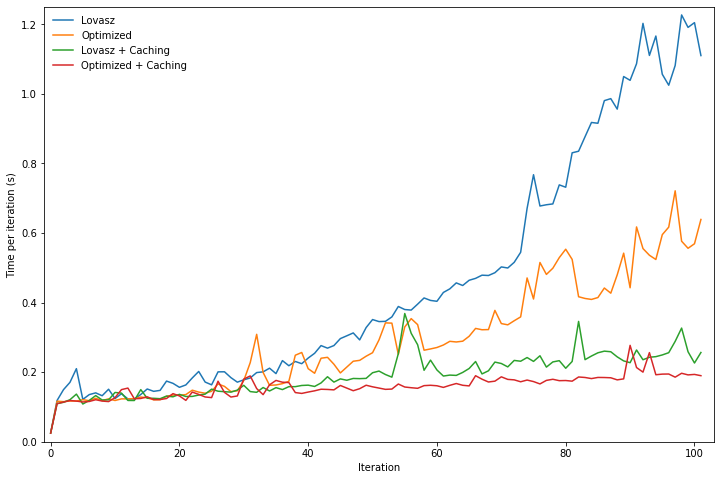

In [34]:
m = 'iter_time' # fscore, iter_time

labels = {
    'strategy=default cache=False': 'Lovasz',
    'strategy=opt cache=False z_cut=True': 'Optimized',
    'strategy=default cache=True':  'Lovasz + Caching',
    'strategy=opt cache=True  z_cut=True': 'Optimized + Caching'
}


mask = ~dfs['strategy=default cache=False'][m].isnull()
idx = dfs['strategy=default cache=False'].index[mask]

plt.figure(figsize=(12, 8))

for label, l in labels.items():
    df = dfs[label]
    plt.plot(idx, df[m].loc[mask], label=l)

plt.ylim([0, 1.25])
plt.xlim([-1, 103])
plt.ylabel('Time per iteration (s)')
plt.xlabel('Iteration')
plt.legend(loc='upper left', frameon=False)
plt.savefig('/Users/luciano/Downloads/ellipsoid_opt.pdf')
plt.show()

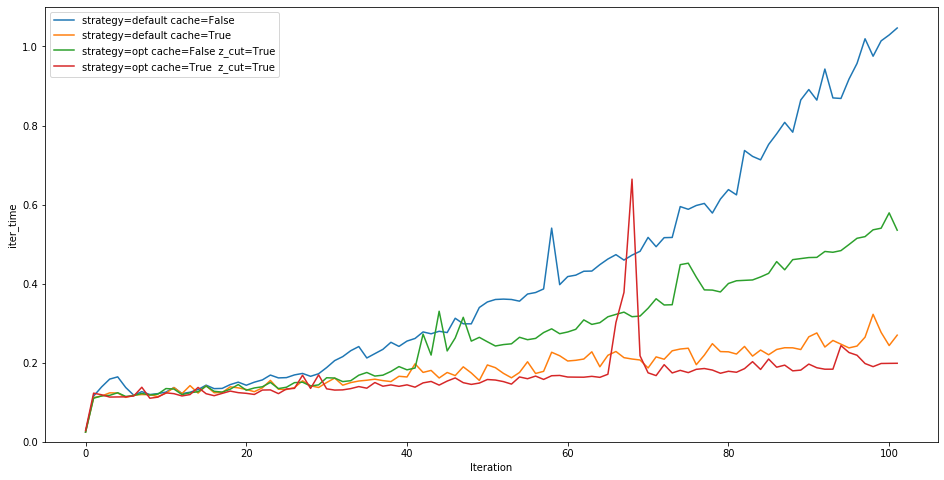

In [15]:
m = 'iter_time' # fscore, iter_time

mask = ~dfs['strategy=default cache=False'][m].isnull()
idx = dfs['strategy=default cache=False'].index[mask]

plt.figure(figsize=(16, 8))

for label, df in dfs.items():
    plt.plot(idx, df[m].loc[mask], label=label)

plt.ylim([0, 1.1])
plt.ylabel(m)
plt.xlabel('Iteration')
plt.legend(loc='best')
plt.show()